In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [6]:
age=[]
gender=[]
img_path=[]
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [7]:
len(age)

23708

In [8]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [9]:
df.shape

(23708, 3)

In [10]:
df.head()

,age,gender,img
0,16,0,16_0_0_20170110232444834.jpg.chip.jpg
1,20,1,20_1_1_20170112231738487.jpg.chip.jpg
2,52,0,52_0_3_20170119200211340.jpg.chip.jpg
3,3,0,3_0_2_20161219160259510.jpg.chip.jpg
4,35,0,35_0_0_20170116193236930.jpg.chip.jpg


In [11]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [29]:
from sklearn.preprocessing import StandardScaler
train_df['age'] = StandardScaler().fit_transform(train_df['age'].values.reshape(-1,1))
test_df['age'] = StandardScaler().fit_transform(test_df['age'].values.reshape(-1,1))

In [30]:
train_df.shape

(20000, 3)

In [31]:
test_df.shape

(3708, 3)

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [33]:
import tensorflow as tf

In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and rescaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Define generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],  # List of target columns
    target_size=(200, 200),
    class_mode='raw',  # Use 'raw' for multi-output targets
    batch_size=32,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],  # List of target columns
    target_size=(200, 200),
    class_mode='raw',  # Use 'raw' for multi-output targets
    batch_size=32,
    shuffle=False
)


Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [35]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model


In [18]:
vgg = VGG16(include_top=False, input_shape=(200,200,3))

In [19]:
from tensorflow.keras.regularizers import l1, l2, l1_l2


In [36]:

vgg.trainable=False

output = vgg.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu', kernel_regularizer=l1(0.01))(flatten)
dense2 = Dense(512, activation='relu', kernel_regularizer=l1(0.01))(flatten)

dense1 = BatchNormalization()(dense1)
dense2 = BatchNormalization()(dense2)

dense3 = Dense(512,activation='relu', kernel_regularizer=l1(0.01))(dense1)
dense4 = Dense(512,activation='relu', kernel_regularizer=l1(0.01))(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [37]:
model1 = Model(inputs=vgg.input,outputs=[output1,output2])

In [38]:
model1.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [39]:
hist1 = model1.fit(train_generator, batch_size=32, epochs=5, validation_data=test_generator)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['bias', 'gamma', 'beta', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 96s 145ms/step - age_mae: 0.6562 - loss: 171.5670 - val_age_mae: 0.6249 - val_loss: 23.5526
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - age_mae: 0.6238 - loss: 23.5192 - val_age_mae: 0.6241 - val_loss: 23.1897
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - age_mae: 0.6231 - loss: 23.4438 - val_age_mae: 0.6242 - val_loss: 23.0077
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 141ms/step - age_mae: 0.6218 - loss: 23.3930 - val_age_mae: 0.6246 - val_loss: 23.2688
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 141ms/step - age_mae: 0.6236 - loss: 23.3662 - val_age_mae: 0.6242 - val_loss: 23.4257


In [40]:
import matplotlib.pyplot as plt


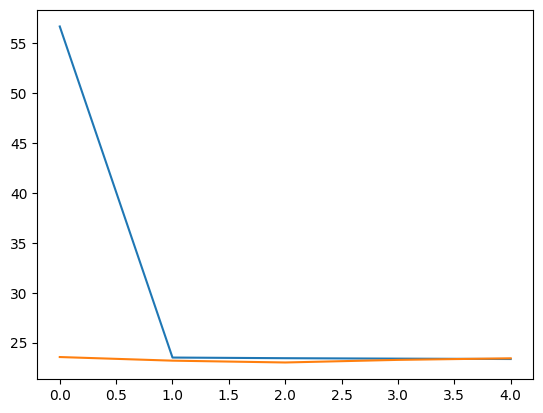

In [41]:
import matplotlib.pyplot as plt
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])

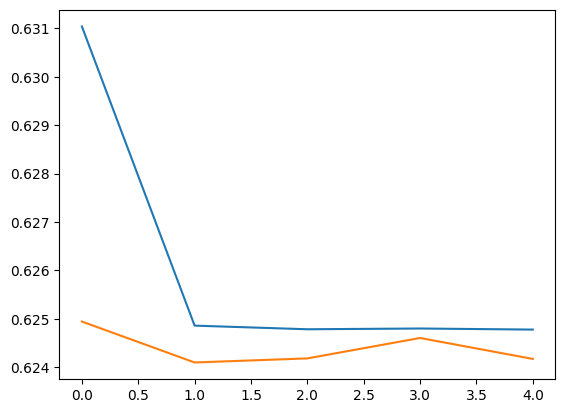

In [42]:
plt.plot(hist1.history['age_mae'])
plt.plot(hist1.history['val_age_mae'])

In [43]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [44]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

In [45]:
resnet = ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output = resnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense = Dropout(0.2)(dense1)
dense2 = Dense(512,activation='relu')(flatten)
dense = Dropout(0.2)(dense1)

dense3 = Dense(512,activation='relu')(dense1)

dense4 = Dense(512,activation='relu')(dense2)

output1 = Dense(1,activation='linear',name='age')(dense3)

output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [46]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

In [47]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'},loss_weights={'age':1,'gender':99})

In [48]:
hist2 = model.fit(train_generator, batch_size=32, epochs=5, validation_data=test_generator)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 118ms/step - age_mae: 2.4910 - loss: 2.4910 - val_age_mae: 0.6244 - val_loss: 0.6244
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 66s 105ms/step - age_mae: 0.6182 - loss: 0.6182 - val_age_mae: 0.6245 - val_loss: 0.6245
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - age_mae: 0.6195 - loss: 0.6195 - val_age_mae: 0.6242 - val_loss: 0.6242
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 83s 107ms/step - age_mae: 0.6270 - loss: 0.6270 - val_age_mae: 0.6248 - val_loss: 0.6248
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 105ms/step - age_mae: 0.6260 - loss: 0.6260 - val_age_mae: 0.6245 - val_loss: 0.6245


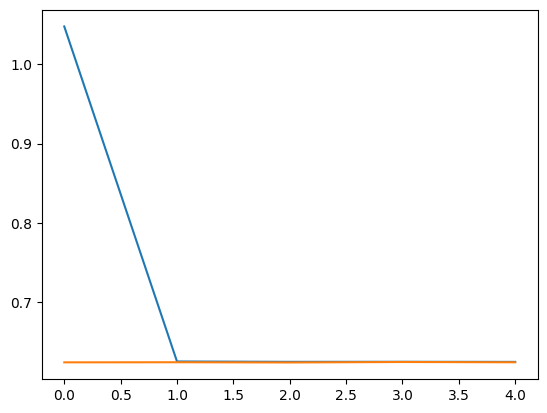

In [49]:
import matplotlib.pyplot as plt
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

KeyError: 'val_age_loss'

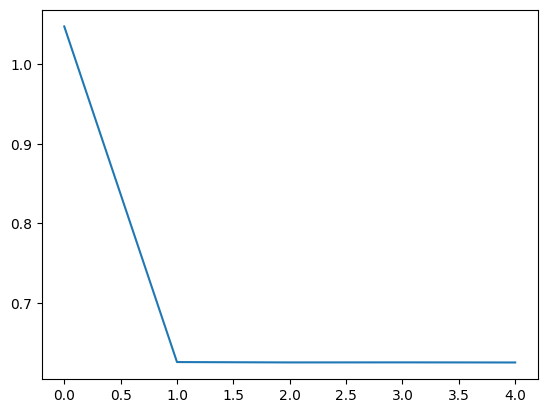

In [50]:
plt.plot(hist2.history['age_mae'])
plt.plot(hist2.history['val_age_loss'])